# Books Analysis and Recommendation System 

The basic idea behind analysing the Goodreads dataset is to get a fair idea about the relationships between the multiple attributes a book might have, such as:the aggregrate rating of each book, the trend of the authors over the years and books with numerous languages. With over a hundred thousand ratings, there are books which just tend to become popular as each day seems to pass. 

We've always conisdered the magical persona books seem to hold, and with this notebook, we step out on a journey to see what kind of books really drives people to read in this era of modern smart devices. 

With such a vast, overwhelming number of factors, we'll go over such demographics: 
- Does any relationship lie between ratings and the total ratings given?
- Where do majority of the books lie, in terms of ratings - Does reading a book really bring forth bias for the ratings?
- Do authors tend to perform same over time, with all their newer books? Or do they just fizzle out. 
- Do number of pages make an impact on reading styles, ratings and popularity?
- Can books be recommended based on ratings? Is that a factor which can work?



> # Loading libraries with installation<a id="1"></a> <br>

In [155]:

import numpy as np 
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from tqdm import tqdm
from progressbar import ProgressBar
import re
from scipy.cluster.vq import kmeans, vq
from pylab import plot, show
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
from sklearn.cluster import KMeans
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [156]:
import warnings
warnings.filterwarnings("ignore")

> # Getting Basic Ideas<a id="2"></a> <br>

In [157]:
df = pd.read_csv('books.csv', error_bad_lines = False)
df = df.rename(columns={'  num_pages': 'num_pages'})

b'Skipping line 3350: expected 12 fields, saw 13\nSkipping line 4704: expected 12 fields, saw 13\nSkipping line 5879: expected 12 fields, saw 13\nSkipping line 8981: expected 12 fields, saw 13\n'


In [158]:
df.index = df['bookID']

In [159]:
#Finding Number of rows and columns
print("Dataset contains {} rows and {} columns".format(df.shape[0], df.shape[1]))


Dataset contains 11123 rows and 12 columns


Let's begin the journey, there seems to be J.K. Rowling, predominantly in the head of this dataframe. Yet, as we've all come to know and love her, there's Mary here too. Let's fix this, just for the sake of brevity with all the numerous listings her books are sure to have. 

In [160]:
df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
bookID,,,,,,,,,,,,
1,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
2,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
4,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
5,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
8,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


Fixing the name for every Harry Potter series to be just J.K. Rowling, the database is nearly ready for EDA

In [161]:
df.replace(to_replace='J.K. Rowling/Mary GrandPré', value = 'J.K. Rowling', inplace=True)



In [162]:
df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
bookID,,,,,,,,,,,,
1,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
2,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
4,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
5,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
8,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


In [163]:
df.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', 'num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher'],
      dtype='object')

#### Columns Description: 

- **bookID** Contains the unique ID for each book/series
- **title** contains the titles of the books
- **authors** contains the author of the particular book
- **average_rating** the average rating of the books, as decided by the users
- **ISBN** ISBN(10) number, tells the information about a book - such as edition and publisher
- **ISBN 13** The new format for ISBN, implemented in 2007. 13 digits
- **language_code** Tells the language for the books
- **Num_pages** Contains the number of pages for the book
- **Ratings_count** Contains the number of ratings given for the book
- **text_reviews_count** Has the count of reviews left by users

# Exploratory Data Analysis<a id="3"></a> <br>

### Which are the books with most occurances in the list?<a id="4"></a> <br>

In [164]:
books = df['title'].value_counts()[:20]
rating = df.average_rating[:20]

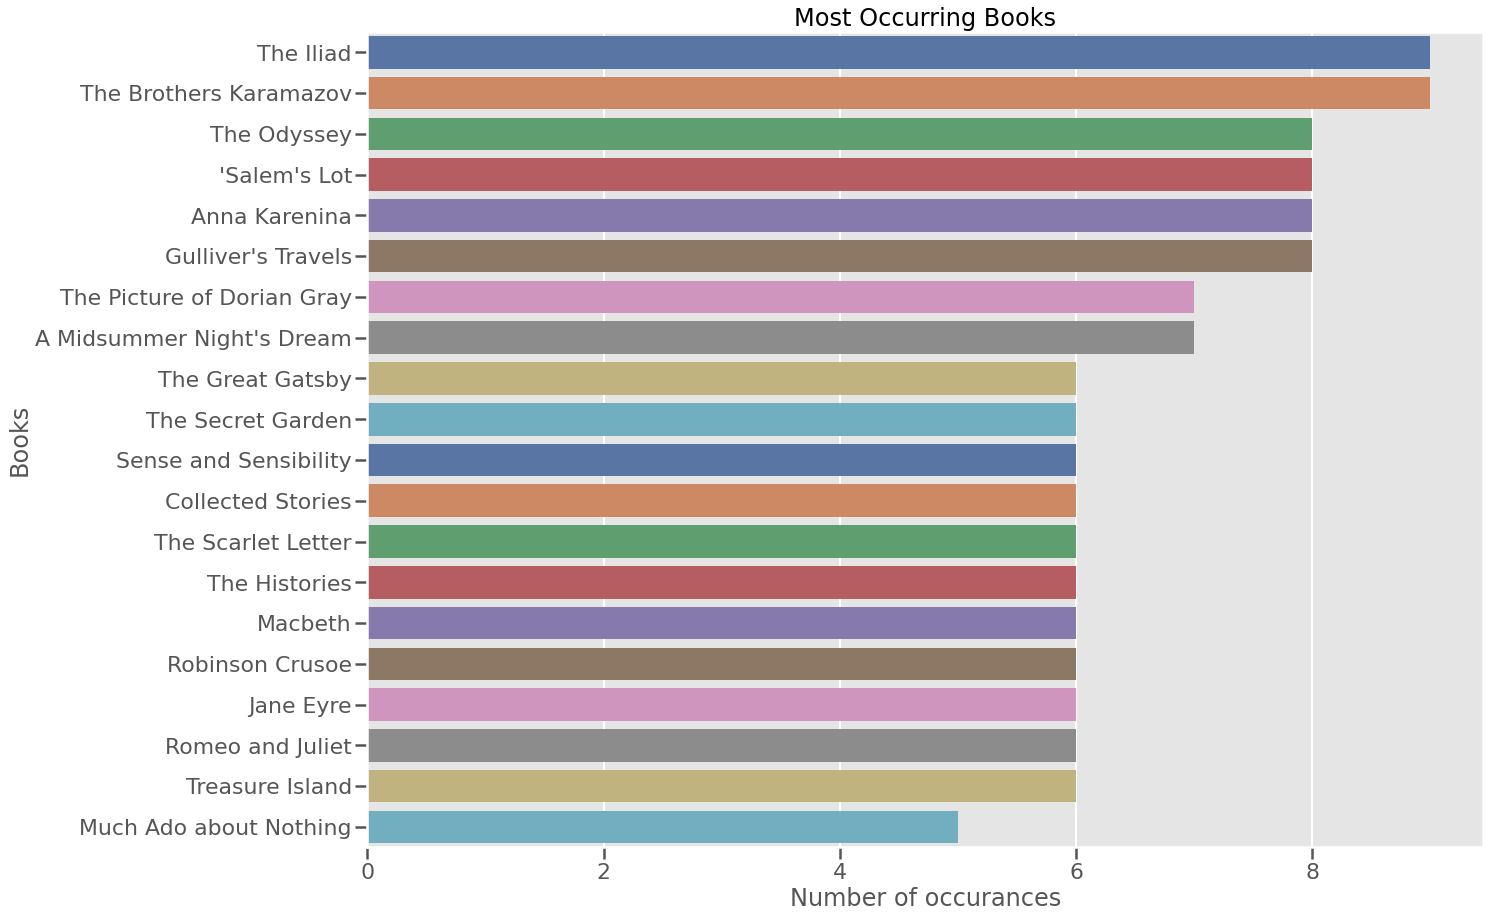

In [165]:
#Taking the first 20:
sns.set_context('poster')
plt.figure(figsize=(20,15))
sns.barplot(x = books, y = books.index, palette='deep')
plt.title("Most Occurring Books")
plt.xlabel("Number of occurances")
plt.ylabel("Books")
plt.show()

We can see that **One Hundred Years Of Solitude** and **Salem's List** have the most number of occurrances with the same name in the data. 

These books have come up in this database over and over again, with various publication editions. From the list, we can see that most of the books from the given chart are either old, steadfast classics or books which are usually assigned to schools. Seems like some books do age well, and these have just braved the flow of time. 

### What is the distribution of books for all languages?<a id="5"></a> <br>

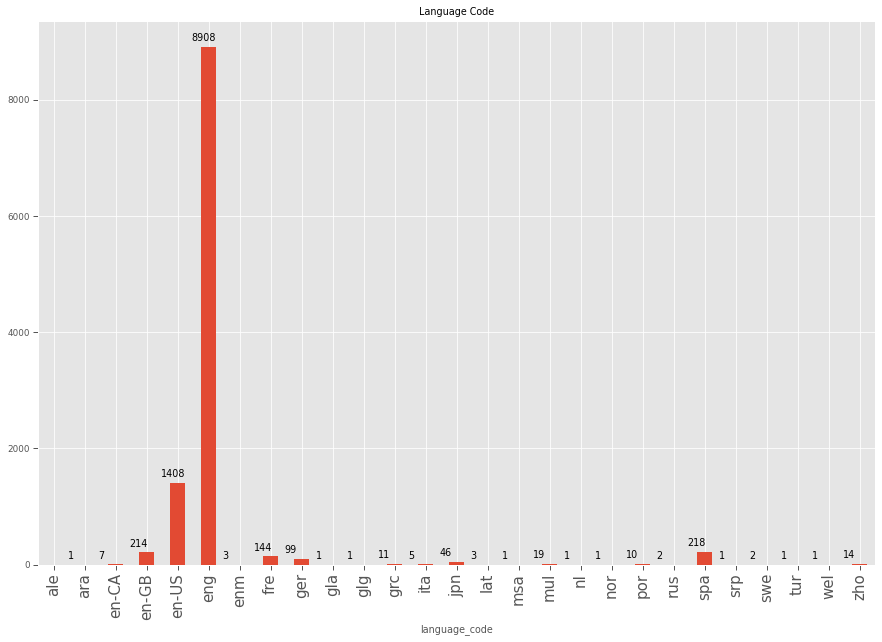

In [166]:
sns.set_context('paper')
plt.figure(figsize=(15,10))
ax = df.groupby('language_code')['title'].count().plot.bar()
plt.title('Language Code')
plt.xticks(fontsize = 15)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()-0.3, p.get_height()+100))

From the given graph, we can infer that in the given data, majority of the books are in english languages, with some further categorised into English-US, english-UK and english-CA.

### Which are the top 10 most rated books?<a id="6"></a> <br>

title
Twilight (Twilight  #1)                                         4597666
The Hobbit  or There and Back Again                             2530894
The Catcher in the Rye                                          2457092
Angels & Demons (Robert Langdon  #1)                            2418736
Harry Potter and the Prisoner of Azkaban (Harry Potter  #3)     2339585
Harry Potter and the Chamber of Secrets (Harry Potter  #2)      2293963
Harry Potter and the Order of the Phoenix (Harry Potter  #5)    2153167
The Fellowship of the Ring (The Lord of the Rings  #1)          2128944
Animal Farm                                                     2111750
Harry Potter and the Half-Blood Prince (Harry Potter  #6)       2095690
Name: ratings_count, dtype: int64

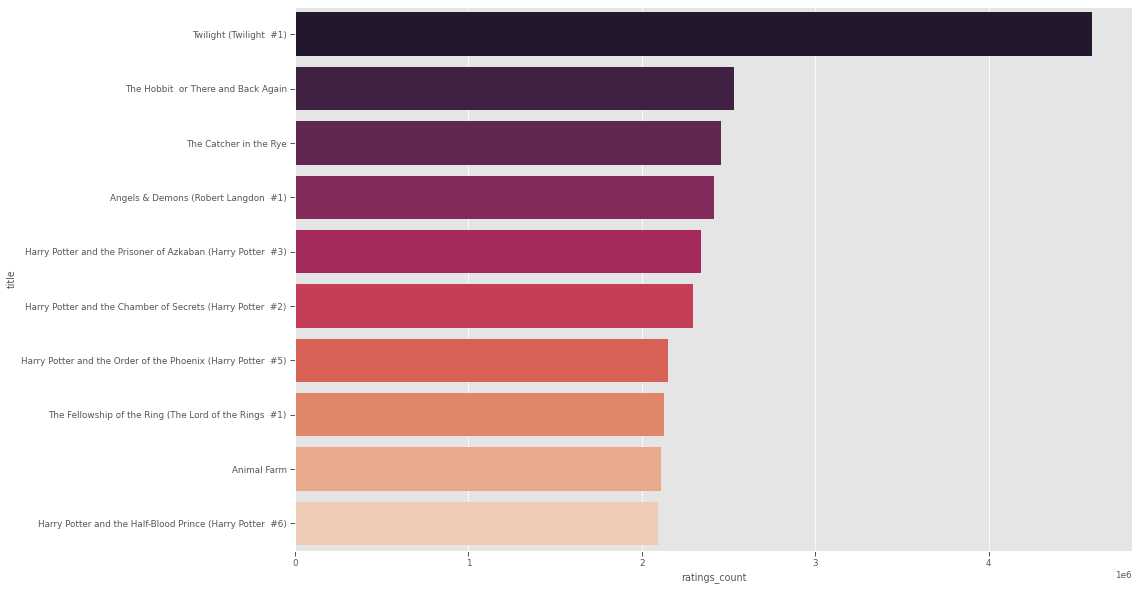

In [167]:
most_rated = df.sort_values('ratings_count', ascending = False).head(10).set_index('title')
plt.figure(figsize=(15,10))
sns.barplot(most_rated['ratings_count'], most_rated.index, palette='rocket')
most_rated['ratings_count']

1 We can see that the beginning books of the series usually have most of the ratings, i.e, **Harry Potter and the Sorcerer's stone**, **Twilight #1**, **The Hobbit**, **Angels and demons #1**.

2 Harry potter's first book dominates the section by having more than 5000000 ratings. Infact, apart from a few, such as Catcher in the Rye and Animal Farm, all of the books seem to be from a series of books, getting the notion into our head that once people begin, most of them seem to dive in with the notion of completing it. 

Yet, when we glance at the first and fifth book of Harry Potter, we can also notice that there has been a ridiculously huge margin in the number of readers/ratings for the books, signifying that there were people who did not pick up the next book in the series and/or only found the first book to touch their hearts up to an extent to drop a vote

### Which are the authors with most books?<a id="7"></a> <br>

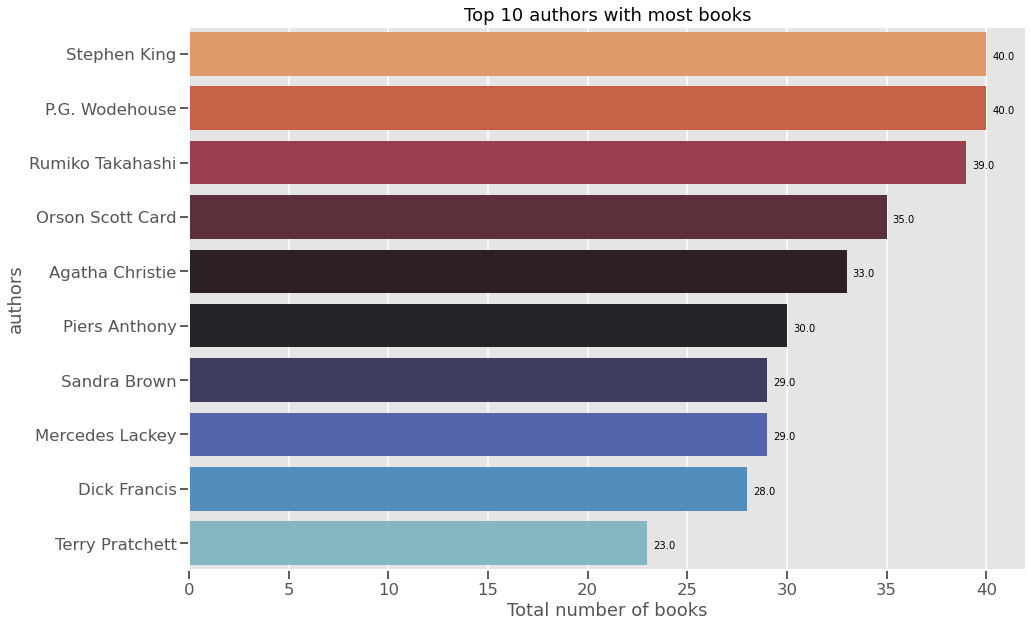

In [168]:
sns.set_context('talk')
most_books = df.groupby('authors')['title'].count().reset_index().sort_values('title', ascending=False).head(10).set_index('authors')
plt.figure(figsize=(15,10))
ax = sns.barplot(most_books['title'], most_books.index, palette='icefire_r')
ax.set_title("Top 10 authors with most books")
ax.set_xlabel("Total number of books")
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+0.5, str(round(i.get_width())), fontsize = 10, color = 'k')

We can see from the above plot that Agatha Christie has the most number of books in the list - although a lot of them might be just various publications for the same book, considering the fact that her work has been here for quite a while, spanning decades.

From the names in the list, we can again gather that most of the authors have either been writing for decades, churning numerous books from time to time, or are authors who are regaled as the 'classics' in our history. 

It seems, hype does play a role in this. 

### Which are the top 10 highly rated authors?<a id="13"></a> <br>

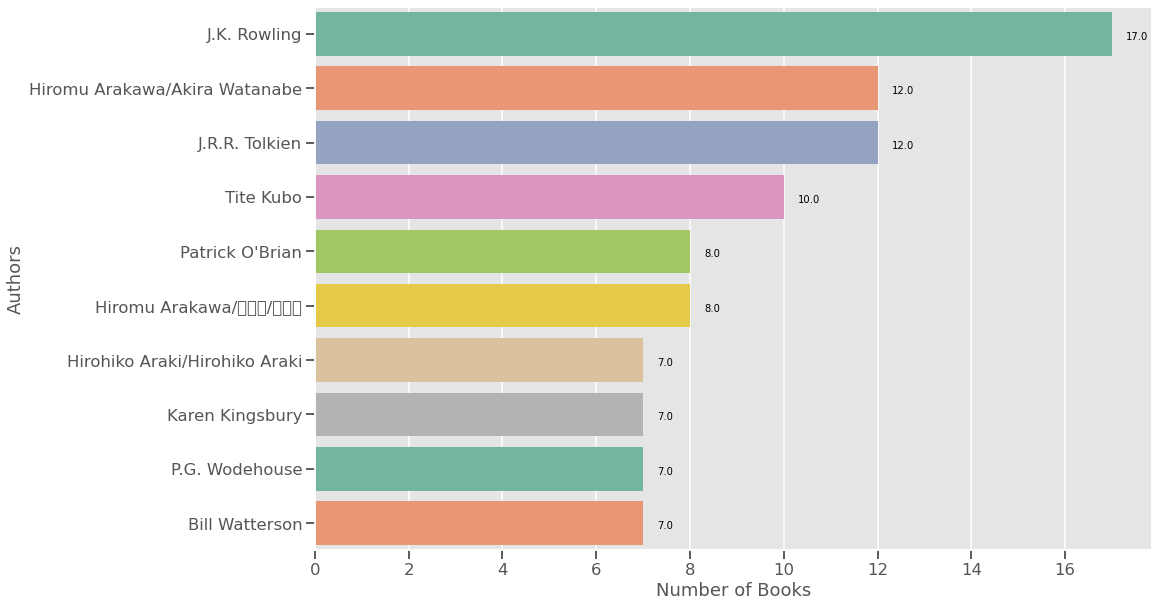

In [169]:
high_rated_author = df[df['average_rating']>=4.3]
high_rated_author = high_rated_author.groupby('authors')['title'].count().reset_index().sort_values('title', ascending = False).head(10).set_index('authors')
plt.figure(figsize=(15,10))
ax = sns.barplot(high_rated_author['title'], high_rated_author.index, palette='Set2')
ax.set_xlabel("Number of Books")
ax.set_ylabel("Authors")
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+0.5, str(round(i.get_width())), fontsize = 10, color = 'k')





We can infer from the plot that J.R.R tolkien has the highest ratings for his books, making his average consistency rather impressive. 

It's also impressive to note the vast dominance Tolkien has over the competition, easily dethroning any other competiton while being above 4.3 in rating.

### What is the rating distribution for the books?<a id="14"></a> <br>

In [170]:

def segregation(data):
    values = []
    for val in data.average_rating:
        if val>=0 and val<=1:
            values.append("Between 0 and 1")
        elif val>1 and val<=2:
            values.append("Between 1 and 2")
        elif val>2 and val<=3:
            values.append("Between 2 and 3")
        elif val>3 and val<=4:
            values.append("Between 3 and 4")
        elif val>4 and val<=5:
            values.append("Between 4 and 5")
        else:
            values.append("NaN")
    print(len(values))
    return values

In [171]:
df.average_rating.isnull().value_counts()

False    11123
Name: average_rating, dtype: int64

In [172]:
df.dropna(0, inplace=True)
#Removing Any null values

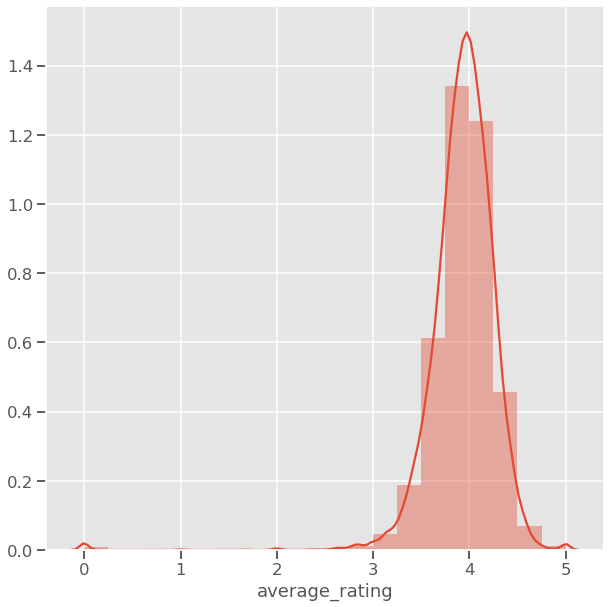

In [173]:
plt.figure(figsize=(10,10))
rating= df.average_rating.astype(float)
sns.distplot(rating, bins=20)



From the given plot, we can infer that: 

- Majority of the ratings lie near 3.7-4.3, approximately.
- Books having scores near 5 are extremely rare

11123


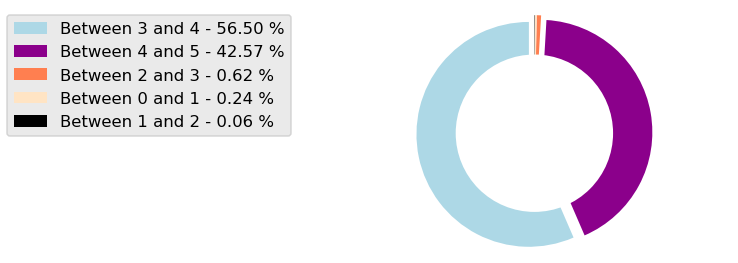

In [174]:
df['Ratings_Dist'] = segregation(df)
ratings_pie = df['Ratings_Dist'].value_counts().reset_index()
labels = ratings_pie['index']
colors = ['lightblue','darkmagenta','coral','bisque', 'black']
percent = 100.*ratings_pie['Ratings_Dist']/ratings_pie['Ratings_Dist'].sum()
fig, ax1 = plt.subplots()
ax1.pie(ratings_pie['Ratings_Dist'],colors = colors, 
        pctdistance=0.85, startangle=90, explode=(0.05, 0.05, 0.05, 0.05, 0.05))
#Draw a circle now:
centre_circle = plt.Circle((0,0), 0.70, fc ='white')
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle)
#Equal Aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')
plt.tight_layout()
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, percent)]
plt.legend( labels, loc = 'best',bbox_to_anchor=(-0.1, 1.),)



Surprisingly, it can be seen that the ratings between 0 and 1 are much more numerous in number, leading to a conclusion that if a person does read a book and end up hating it, it'll still get a minimum of around 2 stars, just for the effort they put up for reading the book. 

The kurtosis of the graph just seems to land between 3 and 4, signifying that for the effort it took to read, and the thrilling, unputdownable nature of the book, the majority of the ratings lie between 3 and 4.

### Is there any relationship between ratings and review counts?<a id="15"></a> <br>


<Figure size 1080x720 with 0 Axes>

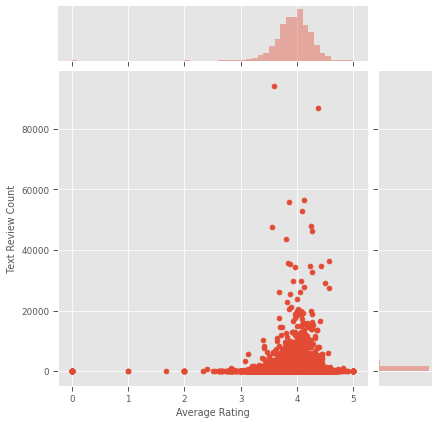

In [175]:
#Checking for any relation between them.
plt.figure(figsize=(15,10))
df.dropna(0, inplace=True)
sns.set_context('paper')
ax =sns.jointplot(x="average_rating",y='text_reviews_count', kind='scatter',  data= df[['text_reviews_count', 'average_rating']])
ax.set_axis_labels("Average Rating", "Text Review Count")
plt.show()



Analysis: We can infer from the plot that most of the ratings for the books seems to lie near 3-4, with a heavy amount of reviews lying barely near 5000, approximately. Let's plot that. 

In [176]:
trial = df[~(df['text_reviews_count']>5000)]

<Figure size 1080x720 with 0 Axes>

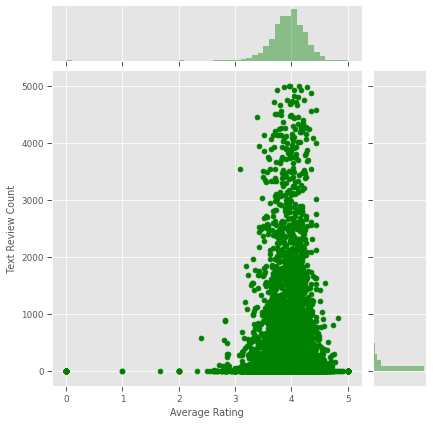

In [177]:
#Checking for any relation between them.
plt.figure(figsize=(15,10))
df.dropna(0, inplace=True)
sns.set_context('paper')
ax =sns.jointplot(x="average_rating",y='text_reviews_count', kind='scatter',  data= trial, color = 'green')
ax.set_axis_labels("Average Rating", "Text Review Count")
plt.show()

It can be observed that even now, the majority of text reviews for books still lie under 1000, making this whole scenario inconclusive. There might be a relationship, but the reviews seem to be predominant amongst books with decent ratings.

Perhaps they are all scam reviews, or the density of the books in that field are just that _more_.

### Is there a relationship between number of pages and ratings?<a id="16"></a> <br>

<Figure size 1080x720 with 0 Axes>

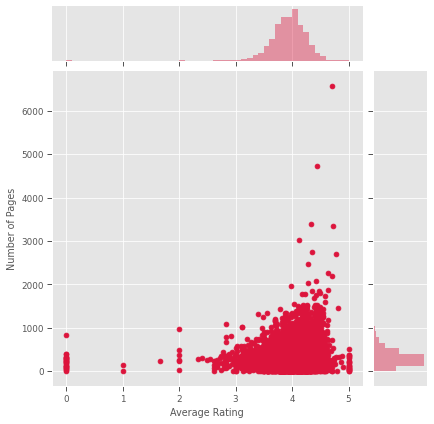

In [178]:
plt.figure(figsize=(15,10))
sns.set_context('paper')
ax = sns.jointplot(x="average_rating", y="num_pages", data = df, color = 'crimson')
ax.set_axis_labels("Average Rating", "Number of Pages")

In [179]:
trial = df[~(df['num_pages']>1000)]

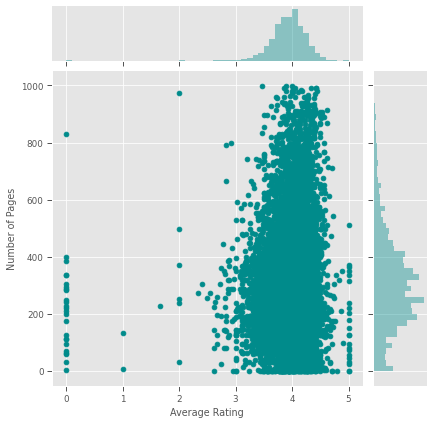

In [180]:
ax = sns.jointplot(x="average_rating", y="num_pages", data = trial, color = 'darkcyan')
ax.set_axis_labels("Average Rating", "Number of Pages")


Analysis: From the given plot, we can infer that the highest ratings ever given, usually are for books with the page range of **200-400**, peaking near 250. It could lead to the fact that most of the people seem to prefer books with a moderate amount of pages, and that thicker books seems to scare people away. 

## Is there a relationship between ratings and ratings count?<a id="17"></a> <br>

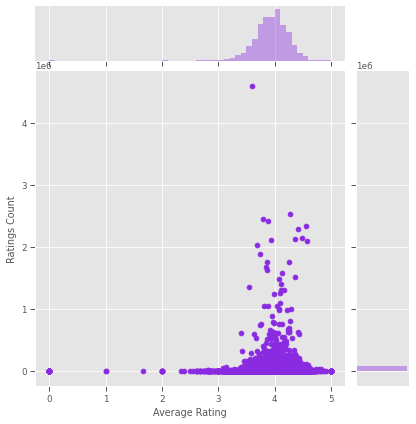

In [182]:
sns.set_context('paper')
ax = sns.jointplot(x="average_rating", y="ratings_count", data = df, color = 'blueviolet')
ax.set_axis_labels("Average Rating", "Ratings Count")


There seem to be some outliers present in this. For a better outlook, let's consider the count around 2000000 ratings

In [183]:
trial = df[~(df.ratings_count>2000000)]

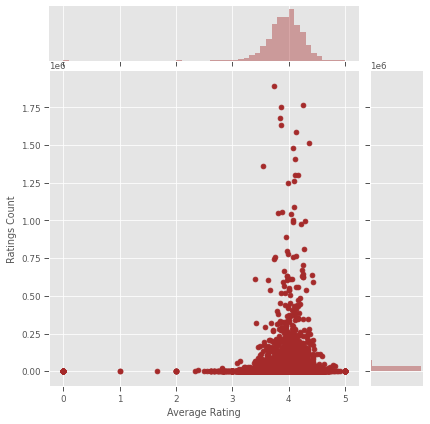

In [184]:
sns.set_context('paper')
ax = sns.jointplot(x="average_rating", y="ratings_count", data = trial, color = 'brown')
ax.set_axis_labels("Average Rating", "Ratings Count")


From the graph, we can see that there can be a potential relationship between the average rating and ratings count. As the number of ratings increase, the rating for the book seems to taper towards 4. The average rating seems to become sparse while the number keeps on decreasing.

From all the above inferences, we can fundamentally decide that although the reviews matter, there can't be any specific relation between them and the ranking for all the books

## Recommendation Engine <a id="22"></a> <br>


Having seen the clustering, we can infer that there can be some recommendations which can happen with the relation between Average Rating and Ratings Count. 

Taking the Ratings_Distribution (A self created classifying trend), the recommendation system works with the algortihm of K Nearest Neighbors. 

Based on a book entered by the user, the nearest neighbours to it would be classified as the books which the user might like. 

KNN is used for both classification and regression problems. In classification problems to predict the label of a instance we first find k closest instances to the given one based on the distance metric and based on the majority voting scheme or weighted majority voting(neighbors which are closer are weighted higher) we predict the labels.

In a setting such as this, the unsupervised learning takes place, with the similar neighbors being recommended. For the given list, if I ask recommendations for "The Catcher in the Rye", five books related to it would appear. 

Creating a books features table, based on the Ratings Distribution, which classifies the books into ratings scale such as: 
- Between 0 and 1
- Between 1 and 2
- Between 2 and 3
- Between 3 and 4
- Between 4 and 5

Broadly, the recommendations then consider the average ratings and ratings cout for the query entered.

In [145]:
books_features = pd.concat([df['Ratings_Dist'].str.get_dummies(sep=","), df['average_rating'], df['ratings_count']], axis=1)

In [146]:
books_features.head()

,Between 0 and 1,Between 1 and 2,Between 2 and 3,Between 3 and 4,Between 4 and 5,average_rating,ratings_count
bookID,,,,,,,
1,0,0,0,0,1,4.57,2095690
2,0,0,0,0,1,4.49,2153167
4,0,0,0,0,1,4.42,6333
5,0,0,0,0,1,4.56,2339585
8,0,0,0,0,1,4.78,41428


The min-max scaler is used to reduce the bias which would have been present due to some books having a massive amount of features, yet the rest having less. Min-Max scaler would find the median for them all and equalize it. 


In [147]:
min_max_scaler = MinMaxScaler()
books_features = min_max_scaler.fit_transform(books_features)

In [148]:
np.round(books_features, 2)

array([[0.  , 0.  , 0.  , ..., 1.  , 0.91, 0.46],
       [0.  , 0.  , 0.  , ..., 1.  , 0.9 , 0.47],
       [0.  , 0.  , 0.  , ..., 1.  , 0.88, 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.79, 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.74, 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.78, 0.  ]])

In [149]:
model = neighbors.NearestNeighbors(n_neighbors=6, algorithm='ball_tree')
model.fit(books_features)
distance, indices = model.kneighbors(books_features)



Creating specific functions to help in finding the book names: 
- Get index from Title
- Get ID from partial name (Because not everyone can remember all the names) 
- Print the similar books from the feature dataset. 
 *(This uses the Indices metric from the nearest neighbors to pick the books.)*

In [150]:
def get_index_from_name(name):
    li = df[df["title"]==name].index.tolist()
    if li:
        return li[0]
    else:
        print('Book not found!')

all_books_names = list(df.title.values)

def get_id_from_partial_name(partial):
    for name in all_books_names:
        if partial in name:
            print(name,all_books_names.index(name))
            
def print_similar_books(query=None,id=None):
    if id:
        for id in indices[id][1:]:
            print(df.iloc[id]["title"])
    if query:
        found_id = get_index_from_name(query)
        for id in indices[found_id][1:]:
            print(df.iloc[id]["title"])

Checking out the Workings of the System, let's try with following examples. 

- System by name: The Catcher in the Rye
- System by Name: The Hobbit
- System by partial name: Harry Potter (Book 5)


#### The Catcher in the Rye:

In [151]:
print_similar_books("The Catcher in the Rye")


Hitchhiker's Guide To The Galaxy: The Filming of the Douglas Adams classic
The Peloponnesian War
Henry and June: From the Unexpurgated Diary of Anaïs Nin
Hemingway & Bailey's Bartending Guide to Great American Writers
Liberty Before Liberalism


In [152]:
print_similar_books("The Hobbit and the ")

Book not found!


#### Harry Potter Book 5:

Since most users won't remember the name for the entire book (Especially how it has been entered in the books database), the function to get ID from the partial names helps to choose to ID of the book the user is looking for. 

In [153]:
get_id_from_partial_name("Harry Potter and the ")

Harry Potter and the Half-Blood Prince (Harry Potter  #6) 0
Harry Potter and the Order of the Phoenix (Harry Potter  #5) 1
Harry Potter and the Chamber of Secrets (Harry Potter  #2) 2
Harry Potter and the Prisoner of Azkaban (Harry Potter  #3) 3
Harry Potter and the Half-Blood Prince (Harry Potter  #6) 0
Harry Potter and the Prisoner of Azkaban (Harry Potter  #3) 3
Harry Potter and the Chamber of Secrets (Harry Potter  #2) 2
Harry Potter and the Sorcerer's Stone (Harry Potter  #1) 8873
Harry Potter and the Philosopher's Stone (Harry Potter  #1) 10674
Harry Potter and the Goblet of Fire (Harry Potter  #4) 10675


In [154]:
print_similar_books(id = 1) #ID for the Book 5

Harry Potter and the Half-Blood Prince (Harry Potter  #6)
The Fellowship of the Ring (The Lord of the Rings  #1)
Harry Potter and the Chamber of Secrets (Harry Potter  #2)
Harry Potter and the Prisoner of Azkaban (Harry Potter  #3)
The Hobbit  or There and Back Again
